In [2]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
##############


In [36]:
def convolution(N, params, iteration = 0):
    # number of parameters is 2*N - 2
    k = 0
    
    M = N if N%2==0 else N - 1
        
    for n in range(0, M, 2):
        for i in range(iteration):
            n = (2*n + 1)
        print(n, n + 2**iteration)  
        
        qml.RY(params[k], wires = n)
        k = k + 1
        qml.RY(params[k], wires = n + 2**iteration)
        k = k + 1
        qml.CNOT(wires=[n, n + 2**iteration])
    
    qml.Barrier()
    
    if N % 2 != 0:
        print(N-1, N-2)
        qml.RY(params[k], wires = N-1)
        k = k + 1
        qml.RY(params[k], wires = N-2)
        k = k + 1
        qml.CNOT(wires=[N-1, N-2])
        
    for n in range(M-2,1,-2):
        for i in range(iteration):
            n = (2*n + 1)
        print(n, n - 2**iteration)  
        
        qml.RY(params[k], wires = n)
        k = k + 1
        qml.RY(params[k], wires = n - 2**iteration)
        k = k + 1
        qml.CNOT(wires=[n, n - 2**iteration])
        
    qml.Barrier()
    

In [50]:
def pooling(N, params, iteration = 0):
    # number of parameters is N + N%2
    k = 0
    
    M = N if N%2==0 else N - 1
    
    for n in range(0, M, 2):
        for i in range(iteration):
            n = (2*n + 1)
        print('M:',n)
        m_0 = qml.measure(n)

        qml.cond(m_0 ==0, qml.RZ)(params[k], wires=n+2**iteration)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=n+2**iteration)
        k = k + 1
    
    if N%2 != 0:
        print('M:',N-1)
        m_0 = qml.measure(N-1)
        qml.cond(m_0 ==0, qml.RZ)(params[k], wires=N-2)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=N-2)
        k = k + 1
    
    qml.Barrier()

In [51]:
np.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], requires_grad=True)

In [65]:
dev = qml.device('default.qubit', wires=8, shots=1000)

@qml.qnode(dev)
def circ(N):
    convolution(N, (2*N-2)*[0])
    pooling(N, (N+N%2)*[0])
    
    N = N//2
    print('-----')
    convolution(N, (2*N-2)*[0], iteration = 1)
    pooling(N, (N+N%2)*[0], iteration = 1)
    
    N = N//2
    pooling(N, [0]*10, iteration = 2)
    return [qml.measure(wires = N-1)

In [66]:
for i in range(0):
    print('ciao')

In [67]:
drawer = qml.draw(circ)
print(drawer(8))

0 1
2 3
4 5
6 7
6 5
4 3
2 1
M: 0
M: 2
M: 4
M: 6
-----
1 3
5 7
5 3
M: 1
M: 5
M: 3


QuantumFunctionError: A quantum function must return either a single measurement, or a nonempty sequence of measurements.

In [319]:
pooling(5,100*[0])

M: 0
M: 2
M: 4


In [ ]:
convolution(5, [0]*100)

TypeError: object of type 'int' has no len()

In [5]:
dev = qml.device('default.qubit', wires=2, shots=1000)

In [122]:
@qml.qnode(dev)
def circ():
    qml.CRY(3.14, wires = [0,1])
    # return <psi|H|psi>
    
    m_0 = qml.measure(1)

    qml.cond(m_0 ==0, qml.RZ)(0, wires=0)
    qml.cond(m_0 ==1, qml.RY)(1, wires=0)
    
    return qml.state()

In [123]:
drawer = qml.draw(circ)
print(drawer())

0: ─╭C────────╭ControlledOperation(0.00)─╭ControlledOperation(1.00)─┤  State
1: ─╰RY(3.14)─╰C─────────────────────────╰C─────────────────────────┤  State


In [16]:
def get_data(train_size = 1000, test_size = 100, grayscale_threshold = .5, reduced = True):
    '''
    Prepare the MNIST dataset for the training algorithm:
     * Choose randomly a subset from the whole dataset
     * Flatten each image to mirror the mps structure
     * Normalize images from [0,255] to [0,1]
     * Apply a threshold for each pixels so that each value 
       below that threshold are set to 0, the others get set to 1.
       For this algorithm we will only deal to binary states {0,1}
       instead of a range from 0 to 1    
    '''
    # Download all data
    mnist = torchvision.datasets.MNIST('classifier_data', train=True, download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]) )
    shape = (28,28)
    # Convert torch.tenor to numpy
    npmnist = mnist.data.numpy()
    
    # Check of the type of the sizes
    #if ((type(train_size) != int) or (type(test_size) != int)):
    #    raise TypeError('train_size and test_size must be INT')
    
    # Check if the training_size and test_size requested are bigger than
    # the MNIST whole size
    if ( (train_size + test_size) > npmnist.shape[0] ):
        raise ValueError('Subset too big') 
    
    # Check of the positivity of sizes
    if ( (train_size <= 0) or (test_size <= 0) ):
        raise ValueError('Size of training set and test set cannot be negative')
    
    # Choose just a subset of the data
    # Creating a mask by randomly sampling the indexes of the full dataset
    subset_indexes = np.random.choice(np.arange(npmnist.shape[0]), size=(train_size + test_size), 
                                      replace=False, p=None)
    
    # Apply the mask
    npmnist = npmnist[subset_indexes]

    # Flatten every image
    npmnist = np.reshape(npmnist, (npmnist.shape[0], npmnist.shape[1]*npmnist.shape[2]))
    
    # Normalize the data from 0 - 255 to 0 - 1
    npmnist = npmnist/npmnist.max()
    
    if reduced:
        # Apply meanpool2d
        ds_imgs = []
        for img in npmnist:
            ds_img = []
            for col in range(0,shape[0],2):
                for row in range(0,shape[1],2):
                    pixel = np.mean([img.reshape(shape)[col,row], img.reshape(shape)[col,row+1],
                                     img.reshape(shape)[col+1,row], img.reshape(shape)[col+1,row+1]])

                    ds_img.append(pixel)

            ds_imgs.append(np.array(ds_img).reshape((shape[0]//2)*(shape[1]//2)) )

        ds_imgs = np.array(ds_imgs)

        ds_imgs[ds_imgs > grayscale_threshold] = 1
        ds_imgs[ds_imgs <= grayscale_threshold] = 0
        
        npmnist = ds_imgs
    
    if ((grayscale_threshold <= 0) or (grayscale_threshold >= 1)):
        raise ValueError('grayscale_threshold must be in range ]0,1[')
    
    npmnist[npmnist > grayscale_threshold] = 1
    npmnist[npmnist <= grayscale_threshold] = 0
    
    # Return training set and test set
    return npmnist[:train_size], npmnist[train_size:]


def plot_img(img_flat, shape, flip_color = True, border = False, savefig = '', title=''):
    '''
    Display the image from the flattened form
    '''
    # If the image is corrupted for partial reconstruction (pixels are set to -1)
    if -1 in img_flat:
        img_flat = np.copy(img_flat)
        img_flat[img_flat == -1] = 0
    plt.figure(figsize = (2,2))
    
    if title != '':
        plt.title(title)
    # Background white, strokes black
    if flip_color:
        plt.imshow(1-np.reshape(img_flat,shape), cmap='gray')
    # Background black, strokes white
    else:
        plt.imshow(np.reshape(img_flat,shape), cmap='gray')
        
    if border:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.axis('off')
    
    if savefig != '':
        # save the picture as svg in the location determined by savefig
        plt.savefig(savefig, format='svg')
        plt.show()

In [22]:
train, test = get_data(train_size = 100, test_size = 10, grayscale_threshold = .5, reduced = True)

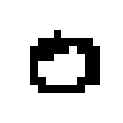

In [25]:
plot_img(train[4], (14,14))

In [ ]:
print